In [1]:
import matplotlib.pyplot as plt
import torch
import torch.distributions as torch_d
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np

from pcs_gumbel_softmax import tx
from pcs_gumbel_softmax import helper as hlp
from pcs_gumbel_softmax import utils
from pcs_gumbel_softmax import autoencoder as ae

# Parameters

In [10]:
# Channel Parameters
chParam = utils.AttrDict()
chParam.M = 64
# chParam.SNR_db = [5, 12, 18, 30]
chParam.SNR_db = [0, 5, 12, 18, 30]

# Auto-Encoder Parameters
aeParam = utils.AttrDict()
aeParam.temperature = 1
aeParam.nLayersEnc  = 1
aeParam.nLayersDec  = 2
aeParam.nFeaturesEnc  = 256
aeParam.nFeaturesDec  = 256

# Training Parameters
trainingParam = utils.AttrDict()
trainingParam.nBatches      = 16
trainingParam.batchSize     = 128*chParam.M
trainingParam.learningRate  = 0.001
trainingParam.iterations    = 31
trainingParam.displayStep   = 5

## Helper Functions

In [3]:
def p_norm(p, x, fun=lambda x: torch.pow(torch.abs(x), 2)):
    return torch.sum(p * fun(x))

In [4]:
def sampler(P_M, B):
    samples = np.zeros((np.sum(np.rint(B*P_M).astype(int)), 0))
    total_occurrences = np.sum(np.rint(B * P_M).astype(int))
    for idx, p in enumerate(P_M):
        occurrences = np.rint(B*p).astype(int)
        samples = np.append(samples, np.ones(occurrences)*(idx))
    np.random.shuffle(samples)
    return samples.astype(int)

In [5]:
def calculate_py_given_x(z, sig2):
    return (1 / (torch.sqrt(2 * torch.pi * sig2))) * torch.exp(-torch.square(z) / (sig2 * torch.tensor(2)))

## Loss Function
The Cross Equivocation must be corrected with an additional term to account for the changing statistics of the information source:
$$CE_{loss} + \sum \limits_{Y_{n}} P(Y_{n}|c_{i})log_{2}(Q_{\theta,P_{M},C_{M}}(c_{m}|Y_{n})$$
Regarding the prior term, the complex representation is reduced from (N,2) to N by means of multiplication. This is because we have a complex AWGN where the Noise is circularly symmetric.
This means:
$$P(Y_{R}Y_{I}|X_{R}X_{I}) = P(Y_{R}|X_{R})P(Y_{I}|_{R}X_{I})$$
While the posterior term is computed from the learned distribution and taking the max.

In [6]:
# CE loss function and correct with additional term
def loss_correction_factor(dec, zhat, sig2):
    q = torch.amax(dec, 1)  # Q(c_i|Y_n) <-- learned
    p = torch.prod(calculate_py_given_x(zhat, sig2), 1)  # P(Y_n|c_i)
    return torch.mean(p * torch.log2(q))

In [7]:
def r2c(x):
    #a = torch.tensor(x, dtype=torch.double)
    return x.type(torch.complex64)

In [8]:
def plot_2D_PDF(const, pmf, db):
    s = pmf * 400
    plt.figure(figsize=(3, 3))
    plt.scatter(const.real, const.imag, s, c="r")
    plt.title(f'SNR = {db} dB')
    plt.grid()
    plt.show()

## Training Loop

---SNR = 0 dB---
epoch 0: Loss = 6.0170 dB - always 1: 1.0
epoch 5: Loss = 5.7706 dB - always 1: 1.0
epoch 10: Loss = 5.5432 dB - always 1: 1.0
epoch 15: Loss = 5.1841 dB - always 1: 1.0
epoch 20: Loss = 4.6911 dB - always 1: 1.0
epoch 25: Loss = 4.1584 dB - always 1: 1.0
epoch 30: Loss = 3.5983 dB - always 1: 1.0
Power should always be one: tensor(1.0000, grad_fn=<SumBackward0>)


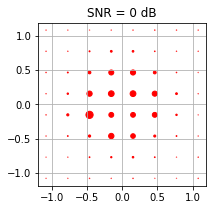

---SNR = 5 dB---
epoch 0: Loss = 5.9943 dB - always 1: 1.0
epoch 5: Loss = 5.8465 dB - always 1: 1.0
epoch 10: Loss = 5.7227 dB - always 1: 1.0
epoch 15: Loss = 5.5921 dB - always 1: 1.0
epoch 20: Loss = 5.4042 dB - always 1: 1.0
epoch 25: Loss = 5.1288 dB - always 1: 1.0
epoch 30: Loss = 4.7026 dB - always 1: 1.0
Power should always be one: tensor(1., grad_fn=<SumBackward0>)


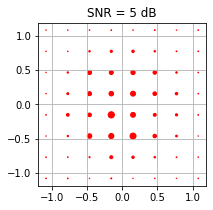

---SNR = 12 dB---
epoch 0: Loss = 5.9898 dB - always 1: 1.0
epoch 5: Loss = 5.9616 dB - always 1: 1.0
epoch 10: Loss = 5.9593 dB - always 1: 1.0
epoch 15: Loss = 5.9571 dB - always 1: 1.0
epoch 20: Loss = 5.9664 dB - always 1: 1.0
epoch 25: Loss = 5.9724 dB - always 1: 1.0
epoch 30: Loss = 5.9743 dB - always 1: 1.0
Power should always be one: tensor(1., grad_fn=<SumBackward0>)


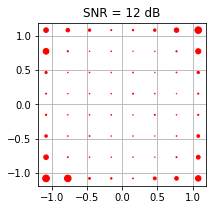

---SNR = 18 dB---
epoch 0: Loss = 5.9978 dB - always 1: 1.0
epoch 5: Loss = 6.0071 dB - always 1: 1.0
epoch 10: Loss = 6.0084 dB - always 1: 1.0
epoch 15: Loss = 6.0035 dB - always 1: 1.0
epoch 20: Loss = 6.0044 dB - always 1: 1.0
epoch 25: Loss = 6.0001 dB - always 1: 1.0
epoch 30: Loss = 5.9936 dB - always 1: 1.0
Power should always be one: tensor(1.0000, grad_fn=<SumBackward0>)


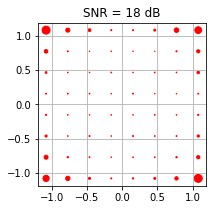

---SNR = 30 dB---
epoch 0: Loss = 5.9907 dB - always 1: 1.0
epoch 5: Loss = 6.0274 dB - always 1: 1.0
epoch 10: Loss = 6.0427 dB - always 1: 1.0
epoch 15: Loss = 6.0456 dB - always 1: 1.0
epoch 20: Loss = 6.0434 dB - always 1: 1.0
epoch 25: Loss = 6.0374 dB - always 1: 1.0
epoch 30: Loss = 6.0315 dB - always 1: 1.0
Power should always be one: tensor(1.0000, grad_fn=<SumBackward0>)


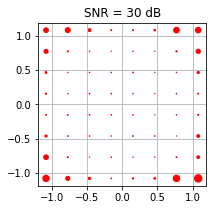

In [11]:
enc_inp = torch.tensor([[1]], dtype=torch.float)

for (k, SNR_db) in enumerate(chParam.SNR_db):
    print(f'---SNR = {chParam.SNR_db[k]} dB---')

    # Initialize network
    encoder = ae.Encoder(in_features=1, width=aeParam.nFeaturesEnc, out_features=chParam.M)
    decoder = ae.Decoder(in_features=2, width=aeParam.nFeaturesDec, out_features=chParam.M)
    CEloss = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=trainingParam.learningRate)

    # Training loop
    for j in range(trainingParam.iterations):
        # first generate the distribution
        l_M = encoder(enc_inp)
        P_M = F.softmax(l_M, dim=1)

        # Sample indexes
        indices = sampler(P_M.detach().numpy()[0], trainingParam.batchSize)  # labels
        # get onehot from sampled indices
        onehot = F.one_hot(torch.tensor(indices, dtype=torch.int64), 64)
        #onehot = np.array([hlp.one_hot(i, chParam.M) for i in indices_t])
        # convert array to tensors
        #onehot_t = torch.tensor(onehot).float()

        # normalization & Modulation
        constellation = tx.qammod(chParam.M)
        constellation_t = torch.tensor(constellation, dtype=torch.cfloat)
        norm_factor = torch.rsqrt(p_norm(P_M, constellation_t))
        norm_constellation = torch.mul(constellation_t, r2c(norm_factor))
        x = torch.matmul(r2c(onehot), torch.transpose(input=norm_constellation, dim0=0, dim1=1))
        should_always_be_one = p_norm(P_M, norm_constellation)

        # Channel
        noise_cpx = torch.complex(torch.randn(x.shape), torch.randn(x.shape))
        # noise_cpx = F.normalize(torch.complex(torch.randn(x.shape), torch.randn(x.shape)))
        #should_always_be_one = p_norm(torch.ones(noise_cpx.shape)/noise_cpx.shape[0], noise_cpx)
        sigma2 = torch.tensor(1) / hlp.dB2lin(SNR_db, 'dB')  # 1 corresponds to the Power
        # noise_snr = r2c(torch.sqrt(sigma2)) * noise_cpx
        noise_snr = r2c(torch.sqrt(sigma2)) * torch.rsqrt(torch.tensor(2)) * noise_cpx
        # https://stats.stackexchange.com/questions/187491/why-standard-normal-samples-multiplied-by-sd-are-samples-from-a-normal-dist-with

        y = torch.add(x, noise_snr)
        #should_always_be_one = p_norm(torch.ones(y.shape)/y.shape[0], y)

        # demodulator
        y_vec = hlp.complex2real(torch.squeeze(y)) #perhaps squeeze before transforming
        dec = decoder(y_vec)


        # loss
        zhat = (y_vec - hlp.complex2real(torch.squeeze(x)))
        loss = CEloss(dec, onehot.type(torch.float))
        loss_hat = loss + loss_correction_factor(F.softmax(dec, 1), zhat, sigma2)

        optimizer.zero_grad()
        loss_hat.backward()
        optimizer.step()

        # Printout and visualization
        if j % int(trainingParam.displayStep) == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy() / np.log(2) :.4f} dB - always 1: {should_always_be_one :.2}')
        if loss < 1e-3:
            break

    # Data for the plots
    p_s_t = F.softmax(encoder(enc_inp), dim=1)
    p_s = p_s_t.detach().numpy()[0]
    constellation = tx.qammod(chParam.M)
    constellation_t = torch.tensor(constellation, dtype=torch.cfloat)
    norm_factor = torch.rsqrt(p_norm(p_s_t, constellation_t))
    norm_constellation = r2c(norm_factor) * constellation_t
    #print(p_s)
    print('Power should always be one:', p_norm(p_s_t, norm_constellation))
    plot_2D_PDF(constellation, p_s, SNR_db)